<a href="https://colab.research.google.com/github/saykim/ds/blob/main/LIME_feature_importance_blogpost_july_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature importance

This notebook is part of the following blogpost: https://medium.com/bigdatarepublic/feature-importance-whats-in-a-name-79532e59eea3

# Install depencencies


In [ ]:
#Install non-standard packages (assuming jupyter notebook)
!pip install shap
!pip install lime
!pip install eli5



    100% |████████████████████████████████| 51kB 1.9MB/s 
    100% |████████████████████████████████| 225kB 4.6MB/s 
    100% |████████████████████████████████| 51kB 8.8MB/s 
  Running setup.py bdist_wheel for shap ... - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/3f/02/ed/0e9e33b2d6db888a19bb161e2d4dc44d3ed1769b093d25301a
  Running setup.py bdist_wheel for iml ... - \ done
  Stored in directory: /content/.cache/pip/wheels/db/89/a8/90abf7a78f2be127f990591529db6890a1caf782f77e7b5cff
Successfully built shap iml
    100% |████████████████████████████████| 266kB 5.1MB/s 
  Running setup.py bdist_wheel for lime ... - \ done
  Stored in directory: /content/.cache/pip/wheels/b8/84/64/feaa6a3aef72109356c4e2be30eef7db76c49d43690eeef113


Successfully built lime
    100% |████████████████████████████████| 102kB 2.7MB/s 
    100% |████████████████████████████████| 51kB 7.0MB/s 
  Running setup.py bdist_wheel for tabulate ... - done
  Stored in directory: /content/.cache/pip/wheels/2a/85/33/2f6da85d5f10614cbe5a625eab3b3aebfdf43e7b857f25f829
Successfully built tabulate


# Import packages

In [ ]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

#scikit-learn package (https://pypi.org/project/scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics.scorer import make_scorer

#eli5 package (https://eli5.readthedocs.io/en/latest)
import eli5
from eli5.sklearn import PermutationImportance

#lime package (https://github.com/marcotcr/lime)
import lime
import lime.lime_tabular

#shap package (https://github.com/slundberg/shap)
import shap

# Load data and train model

In [ ]:
#Load Wisconsin diagnostic breast cancer data from UCI #

url_prefix = "https://archive.ics.uci.edu/ml/machine-learning-databases/"
#if url url does not work you can use this mirror instead:
#url_prefix = "http://mlr.cs.umass.edu/ml/machine-learning-databases/"

data_url = url_prefix + "breast-cancer-wisconsin/wdbc.data"

#Define column labels 
id_status = ["ID", "diagnosis"]

#Mean, standard error and maximum ('worst') values are available for features 
#computed on a collection of cells in a tissue 
column_labels = itertools.product(["radius", "texture", "perimeter", "area",
                                  "smoothness", "compactness", "concavity",
                                  "concave_points", "symmetry", "fractal_dim"],
                                 ["mean","std","max"])

column_labels = id_status + [f"{t}_{f}" for f, t in column_labels]

#Read into pandas DataFrame
df = pd.read_csv(data_url, header=None, names = column_labels)

#Define feature set
X = df.drop('ID', axis=1).drop('diagnosis', axis=1)

#Define diagnosis as integer: malignant (1) or benign (0)
y = (df['diagnosis'] == "M")*1

#Split train and test set.
RANDOM_STATE = 123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)

#Train random forest classification model
model = RandomForestClassifier(max_depth=4, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Diagnosis prediction
y_predict = model.predict(X_test)

# Probability of malignant tissue produced by the model
y_prob = [probs[1] for probs in model.predict_proba(X_test)]



# Evaluate model

Test accuracy: 0.93


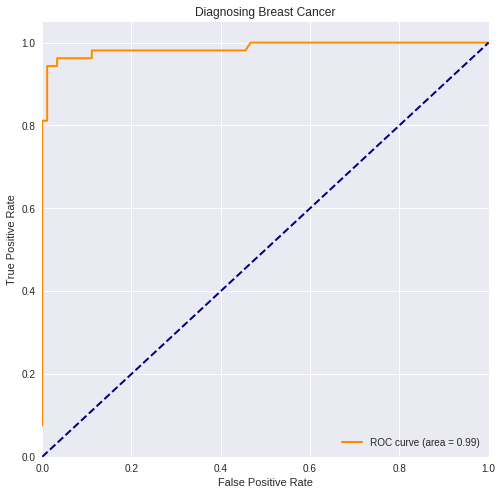

In [ ]:
#Accuracy on test set
print(f"Test accuracy: {accuracy_score(y_test, y_predict).round(2)}")

# Confusion matrix test set
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Benign', 'Predicted Malignant'],
    index=['Benign', 'Malignant']
)

# Compute area under the curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

#Set default figure size
plt.rcParams['figure.figsize'] = (8,8)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Diagnosing Breast Cancer")
plt.legend(loc="lower right")
plt.show()


# Model-specific feature importance

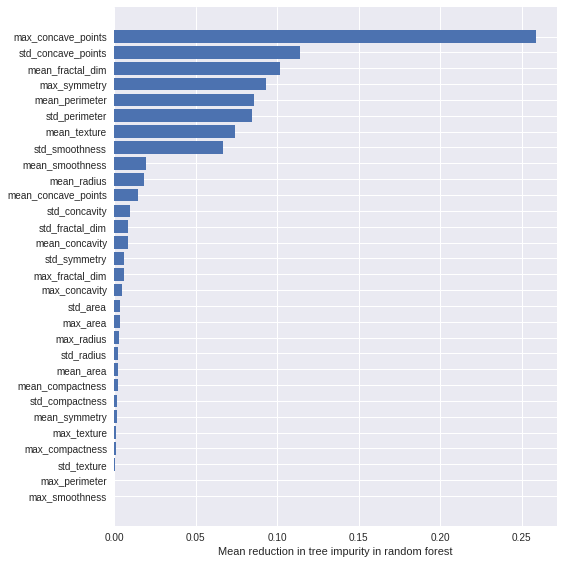

In [ ]:
# Feature importance dataframe
imp_df = pd.DataFrame({'feature': X_train.columns.values,
                       'importance': model.feature_importances_})
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='importance')
imp_range=range(1,len(imp_df.index)+1)
 
## Barplot with confidence intervals
height = ordered_df['importance']
bars = ordered_df['feature']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Mean reduction in tree impurity in random forest")

plt.tight_layout()
# Show graphic
plt.show()



# Permutation feature importance

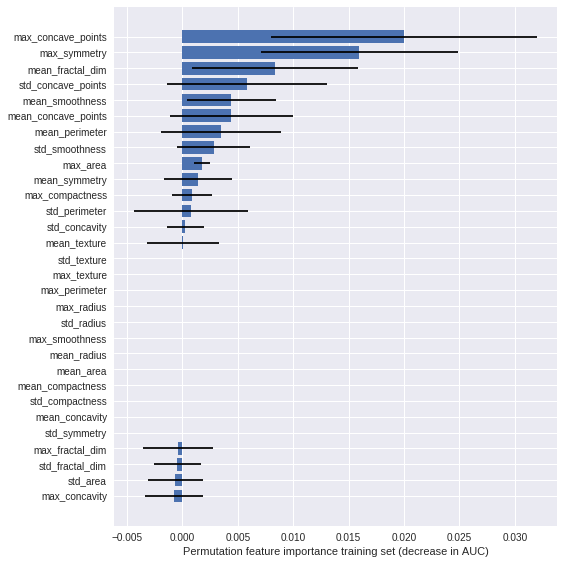

In [ ]:
# Feature importance based on TRAINING set

perm_test = PermutationImportance(model, scoring=make_scorer(roc_auc_score),
                                   n_iter=50, random_state=RANDOM_STATE, cv="prefit")

# fit and see the permuation importances
perm_test.fit(X_train, y_train)

imp_df = eli5.explain_weights_df(perm_test)
label_df = pd.DataFrame({'feature': [ "x" + str(i) for i in range(len(X_test.columns))], 'feature_name': X_test.columns.values})
imp_df = pd.merge(label_df, imp_df, on='feature', how='inner', validate="one_to_one")
 
# Reorder by importance
ordered_df = imp_df.sort_values(by='weight')
imp_range=range(1,len(imp_df.index)+1)
 

## Barplot with confidence intervals

height = ordered_df['weight']
bars = ordered_df['feature_name']
ci = 1.96 * ordered_df['std']
y_pos = np.arange(len(bars))

# Create horizontal bars
plt.barh(y_pos, height, xerr=ci)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel("Permutation feature importance training set (decrease in AUC)")
plt.tight_layout()

# Show graphic
plt.show()




# LIME

Intercept 0.29178400159164875
Prediction_local [0.84797304]
Right: 0.9962788065095202


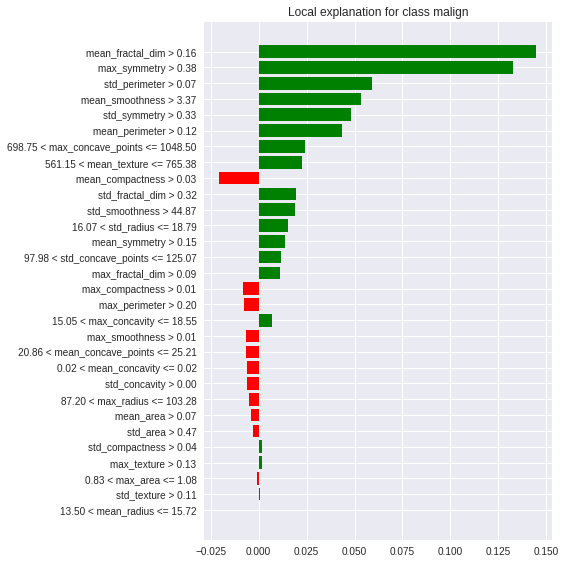

In [ ]:
#Explain samples in test set
X_explain = X_test
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train.values,
                                                   feature_names=X_train.columns.values,
                                                   discretize_continuous=True,
                                                   class_names=["benign", "malign"],
                                                   mode="classification",
                                                   verbose=True,
                                                   random_state=RANDOM_STATE)

#Explaining first subject in test set using all 30 features
exp = explainer.explain_instance(X_explain.values[0,:],model.predict_proba, 
                                 num_features=30)
#Plot local explanation
plt = exp.as_pyplot_figure()
plt.tight_layout()
exp.show_in_notebook(show_table=True)

In [ ]:
# explain the model's predictions on test set using SHAP values
# same syntax works for xgboost, LightGBM, CatBoost, and some scikit-learn models
explainer = shap.TreeExplainer(model)

# shap_values consists of a list of two matrices of dimension samplesize x #features
# The first matrix uses average nr of benign samples as base value
# The second matrix which is used below uses average nr of malignant samples as base value 
shap_values = explainer.shap_values(X_explain)


# Interactive visualization of the explanation of the first subject
# in the test set (X_explain).
# It shows the relative contribution of features to get from the base value of malignant
# samples(average value)
# to the output value (1 in case of malignant sample)
# the numbers at the bottom show the actual values for this sample.
shap.initjs() #initialize javascript in cell
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_explain.iloc[0,:])


In [ ]:
#Interactive visualization of all sample/feature Shapley values
#It is possible to show the relative contribution of individual features for all
# samples on the y-axis as well.
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_explain)

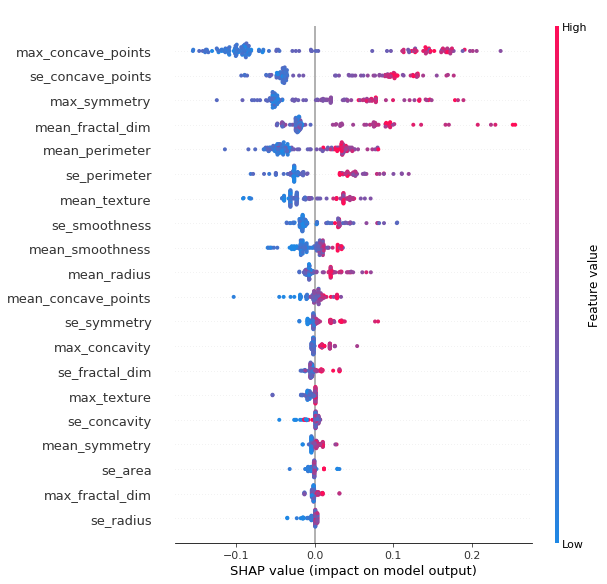

In [ ]:
#A summary plot with the shapley value (feature importance) 
shap.summary_plot(shap_values[1], X_explain)

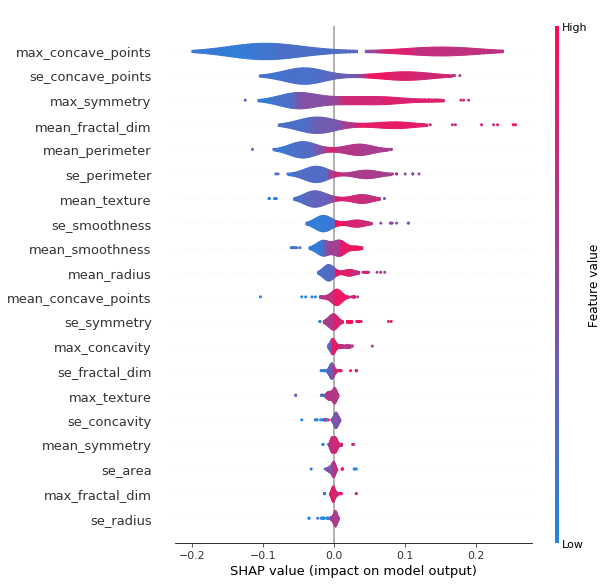

In [ ]:
#Same as above, but with violin plots to better see the distribution of shapley values 
shap.summary_plot(shap_values[1], X_explain, plot_type="violin")